In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
# from off_pol_eval_functions import * 
import sys
import numpy as np
import scipy
import scipy.stats
from scipy.spatial.distance import cdist
import csv
from sklearn import tree
from sklearn import linear_model, neighbors, ensemble, tree

# from warfarin_functions import * 

ntrs = np.arange(100,2501,100)
runsper = 4
runsperper = 25
params = [ntr for ntr in ntrs for run in range(runsper)]

myid = 0#int(sys.argv[1])
# np.random.seed(myid)
ntr = 1000#params[myid-1]

f = open('warfrin.csv','rU')
csvr = csv.reader(f, dialect=csv.excel)
header = np.array(next(csvr))
data   = list(csvr)
f.close()

# filter only to subjects that reached stable dose of warfarin
# and stable observed INR
data = [x for x in data if x[37]=='1' and x[38]!='NA' and x[39]!='NA']

agegroups = sorted(set(x[8].replace('NA','') for x in data))

# %%
xmap = lambda x: \
[
    # gender 0
    ('Male?',x[3]=='male'),
    # race 1:4
    ('White?',x[5]=='White'),
    ('Asian?',x[5]=='Asian'),
    ('Black?',x[5]=='Black or African American'),
    # ethnicity 4
    ('Non-hispanic?',x[7]=='not Hispanic or Latino'),
    # age 5:7
    ('Age group',agegroups.index(x[8]) if x[8] in agegroups else 0),
    ('No age?',x[8] not in agegroups or agegroups.index(x[8]) == 0),
    # height 7
    ('Height',float(x[9]) if x[9] not in ('NA', '') else 0.),
        # x[9] in ('NA', ''), # NA indicator
    # weight 8
    ('Weight',float(x[10]) if x[10] not in ('NA', '') else 0.),
        # x[10] in ('NA', ''), # NA indicator
    # BMI
    ('BMI',float(x[10])*100.*100./float(x[9])/float(x[9]) if x[10] not in ('NA', '') and x[9] not in ('NA', '') else 0.),
] + [# Indication for Warfarin Treatment 9:17
    ('Indication for Warfarin Treatment: '+str(i), str(i) in x[11])
    for i in range(1,9)
# ] + [# comorbidities
#     c in (y.strip() for y in x[12].lower().split('; '))
#     for c in comorbidities
] + [# diabetes 17:19
    ('Diabetes=0?',x[13]=='0'),
    ('Diabetes=1?',x[13]=='1'),
] + [#Congestive Heart Failure and/or Cardiomyopathy 19:21
    ('Congestive Heart Failure and/or Cardiomyopathy=0?',x[14]=='0'),
    ('Congestive Heart Failure and/or Cardiomyopathy=1?',x[14]=='1'),
] + [#Valve Replacement 21:23
    ('Valve Replacement=0?',x[15]=='0'),
    ('Valve Replacement=1?',x[15]=='1'),
# ] + [# medications
#   x[16]
] + [
    # Aspirin 24:26
    ('aspirin=0?',x[17]=='0'),
    ('aspirin=1?',x[17]=='1'),
    # Acetaminophen or Paracetamol (Tylenol) 26:28
    ('Acetaminophen=0?',x[18]=='0'),
    ('Acetaminophen=1?',x[18]=='1'),
    # Was Dose of Acetaminophen or Paracetamol (Tylenol) >1300mg/day 28:30
    ('Acetaminophen hi dose=0?',x[19]=='0'),
    ('Acetaminophen hi dose=1?',x[19]=='1'),
    # Simvastatin (Zocor) 30:32
    ('Simvastatin=0?',x[20]=='0'),
    ('Simvastatin=1?',x[20]=='1'),
    # Atorvastatin (Lipitor) 32:34
    ('Simvastatin=0?',x[21]=='0'),
    ('Simvastatin=1?',x[21]=='1'),
    # Fluvastatin (Lescol) 34:36
    ('Fluvastatin=0?',x[22]=='0'),
    ('Fluvastatin=1?',x[22]=='1'),
    # Lovastatin (Mevacor) 36:38
    ('Lovastatin=0?',x[23]=='0'),
    ('Lovastatin=1?',x[23]=='1'),
    # Pravastatin (Pravachol) 38:40
    ('Pravastatin=0?',x[24]=='0'),
    ('Pravastatin=1?',x[24]=='1'),
    # Rosuvastatin (Crestor) 40:42
    ('Rosuvastatin=0?',x[25]=='0'),
    ('Rosuvastatin=1?',x[25]=='1'),
    # Cerivastatin (Baycol) 42:43
    ('Cerivastatin=0?',x[26]=='0'),
    ('Cerivastatin=1?',x[26]=='1'),
    # Amiodarone (Cordarone)
    ('Amiodarone=0?',x[27]=='0'),
    ('Amiodarone=1?',x[27]=='1'),
    # Carbamazepine (Tegretol)
    ('Carbamazepine=0?',x[28]=='0'),
    ('Carbamazepine=1?',x[28]=='1'),
    # Phenytoin (Dilantin)
    ('Phenytoin=0?',x[29]=='0'),
    ('Phenytoin=1?',x[29]=='1'),
    # Rifampin or Rifampicin
    ('Rifampin=0?',x[30]=='0'),
    ('Rifampin=1?',x[30]=='1'),
    # Sulfonamide Antibiotics
    ('Sulfonamide Antibiotics=0?',x[31]=='0'),
    ('Sulfonamide Antibiotics=1?',x[31]=='1'),
    # Macrolide Antibiotics
    ('Macrolide Antibiotics=0?',x[32]=='0'),
    ('Macrolide Antibiotics=1?',x[32]=='1'),
    # Anti-fungal Azoles
    ('Anti-fungal Azoles=0?',x[33]=='0'),
    ('Anti-fungal Azoles=1?',x[33]=='1'),
    # Herbal Medications, Vitamins, Supplements
    ('Herbal Medications, Vitamins, Supplements=0?',x[34]=='0'),
    ('Herbal Medications, Vitamins, Supplements=1?',x[34]=='1'),
] + [
    #smoker
    ('Smoker=0?',x[40]=='0'),
    ('Smoker=0?',x[40]=='1'),
] + [
    # CYP2C9 consensus
    ('CYP2C9 *1/*1',x[59]=='*1/*1'),
    ('CYP2C9 *1/*2',x[59]=='*1/*2'),
    ('CYP2C9 *1/*3',x[59]=='*1/*3'),
    ('CYP2C9 NA',x[59]=='' or x[59]=='NA'),
    # VKORC1 -1639 consensus
    ('VKORC1 -1639 A/A',x[60]=='A/A'),
    ('VKORC1 -1639 A/G',x[60]=='A/G'),
    ('VKORC1 -1639 G/G',x[60]=='G/G'),
    # VKORC1 497 consensus
    ('VKORC1 497 T/T',x[61]=='T/T'),
    ('VKORC1 497 G/T',x[61]=='G/T'),
    ('VKORC1 497 G/G',x[61]=='G/G'),
    # VKORC1 1173 consensus
    ('VKORC1 1173 T/T',x[62]=='T/T'),
    ('VKORC1 1173 C/T',x[62]=='C/T'),
    ('VKORC1 1173 C/C',x[62]=='C/C'),
    # VKORC1 1542 consensus
    ('VKORC1 1542 C/C',x[63]=='C/C'),
    ('VKORC1 1542 C/G',x[63]=='C/G'),
    ('VKORC1 1542 G/G',x[63]=='G/G'),
    # VKORC1 3730 consensus
    ('VKORC1 3730 A/A',x[64]=='A/A'),
    ('VKORC1 3730 A/G',x[64]=='A/G'),
    ('VKORC1 3730 G/G',x[64]=='G/G'),
    # VKORC1 2255 consensus
    ('VKORC1 2255 C/C',x[65]=='C/C'),
    ('VKORC1 2255 C/T',x[65]=='C/T'),
    ('VKORC1 2255 T/T',x[65]=='T/T'),
    # VKORC1 -4451 consensus
    ('VKORC1 -4451 C/C',x[66]=='C/C'),
    ('VKORC1 -4451 A/C',x[66]=='A/C'),
    ('VKORC1 -4451 A/A',x[66]=='A/A')
#     ,
#     ('Therapeutic Dose',float(x[38]) if x[38] not in ('NA', '') else 0.),
#     ('INR On Therapeutic Dose',float(x[39]) if x[39] not in ('NA', '') else 0.),
#     ('Target INR', float(x[35]) if x[35] not in ('NA', '') else 0. )
]
# %%
X = np.array([list(zip(*xmap(x)))[1] for x in data])
Xnames = np.array(list(zip(*xmap(data[0])))[0])

goodidx = np.where(X.std(axis=0) >= 0.05)[0]
X = X[:, goodidx]
Xnames = Xnames[goodidx]

# Filter out by where BMI is nonzero (assumes BMI is at column index 9 after filtering)
goodbmi = np.where(X[:, 9] > 0.003)[0]
X = X[goodbmi, :]

# Extract target and observed INR values, handling missing values
target_INR = np.array([float(x[35]) if x[35] not in ('NA', '') else 0.0 for x in data])
therapeut_dose = np.array([float(x[38]) if x[38] not in ('NA', '') else 0.0 for x in data])
obs_INR = np.array([float(x[39]) if x[39] not in ('NA', '') else 0.0 for x in data])

# Apply same goodbmi filtering
target_INR = target_INR[goodbmi]
therapeut_dose = therapeut_dose[goodbmi]
obs_INR = obs_INR[goodbmi]

n = X.shape[0]

print(n)

3964


In [4]:
X.shape[1]

81

International Normalised Ratio (INR) testing is well established as an integral part of warfarin treatment. INR has a critical role in maintaining the warfarin response within a therapeutic range, to provide the benefits of anticoagulation, while avoiding the risks of haemorrhage (Figure 1).

The INR is defined as

$$ INR =\left( \frac{\text{Patient Prothrombin Time (sec)}}{\text{Local Geometric Mean Prothrombin Time (sec)}}\right)^{ISI} $$

http://www.bpac.org.nz/BT/2010/November/inr.aspx

In most situations the INR target is 2.5 (target range 2.0 – 3.0). This range is appropriate for the prophylaxis or treatment of venous thromboembolism and reduction of the risk of systemic embolism for people with atrial fibrillation and valvular heart disease.5 In some situations higher ranges are more appropriate. The target INR may vary depending on individual clinical situations. The target INR for mechanical prosthetic valves is dependent on the type of valve replacement used.6



### Semi-simulated dosages

We can generate semi-simulated dosages from the true therapeutic dose by modeling dosage as a function of BMI and perturbing with some noise via a mixture model: 

$$T_i' = \mu_{T^*} + \sigma_{T^*} \sqrt{\theta} \frac{x_{BMI}- \mu_{BMI}}{\sigma_{BMI}} + \sqrt{(1 - \theta)} \sigma_{T^*} \epsilon$$

Suppose that the counterfactual outcome is given by a quadratic penalty to the INR outcome of the observed therapeutic dose: 

$$y_i' = y_i^* + \frac{(T_i' - T_i)^2sgn(T_i' - T_i)}{max(T_i^2, T_i'^2)}$$

This model also yields the propensity score for assigning the counterfactual dose. 
### Propensity score given our treatment generation model from BMI : 
   
where $\epsilon \sim N(0,1)$ and $Z_{BMI} = \frac{x_{BMI} - \mu_{BMI}}{\sigma_{BMI}}$

$$ \mathbb{P}[T_i'=t \mid x_{bmi} ] = \mathbb{P}\left[\epsilon = \frac{t - \mu_T^* - \sigma_T^* \sqrt{\theta}Z_{BMI}}{\sqrt{1 - \theta}} \right]$$


### Dosing policy evaluation and optimization 

In any observational dataset, we will not have access to the full counterfactual distribution of outcomes. Previous analysis of the Warfarin dataset has focused on predicting being in a discrete bin of the "correct" therapeutic dose, e.g. Hamsa Bastani, Bertsimas/Kallus introducing 0-1 loss for being in the same bin. Other work (Chen, Zeng, Kosorok) look at a direct model of the outcome and directly penalize 

We leverage the rich previous study of the impacts of warfarin dosing, treating these models and analyses as "oracle information" we use to simulate realistic outcome data. We consider previous studies analyzing the effect that different INR levels have on the odds ratios for complications including ischemic stroke and hemorrhagic complications. The intensity of anticoagulation induced by warfarin therapy trades off between decreased stroke prevention at low levels of INR (less effective anticoagulation), and increased risk of intracranial bleeding in over-anticoagulation regimes. Various factors such as patient age and pre-existing health conditions (previous stroke) affect patient risk in ways that have been previously studied, but we do not directly account for in this simulated study.

Proposed model: 

* Generate simulated doses as $T_i' = \mu_{T^*} + \sigma_{T^*} \sqrt{\theta} \frac{x_{BMI}- \mu_{BMI}}{\sigma_{BMI}} + \sqrt{(1 - \theta)} \sigma_{T^*} \epsilon$
* Simulate INR response to dose adjustment (inversion of dosage guidelines) <https://depts.washington.edu/anticoag/home/content/warfarin-maintenance-dosing-nomogram>: $\hat{y}(T_i')$
* Compute expected risk as a function of how the odds ratio is affected by INR [ACC/AHA/ESC 2006 guidelines for the management of patients with atrial fibrillation](https://academic.oup.com/europace/article/8/9/651/530495/ACC-AHA-ESC-2006-guidelines-for-the-management-of): $R(\hat{y}(T_i')$
* Compare $R(\hat{y}(\tau(X_i))$ across policies $\tau$


Optimization Question: 

If one generates a dataset of simulated dose adjustments and INR responses in this fashion, can you recover the therapeutic dose (or an optimal linear treatment policy which is similar) if you do off-policy optimization? What kind of treatment policy does the optimization return? 


17.041909862999546
17.21068727968127
[ 2.17774307e+00 -4.20752531e-03  8.79925747e+00 ...  2.27090599e+01
  5.13156233e+01 -2.91905521e-02]


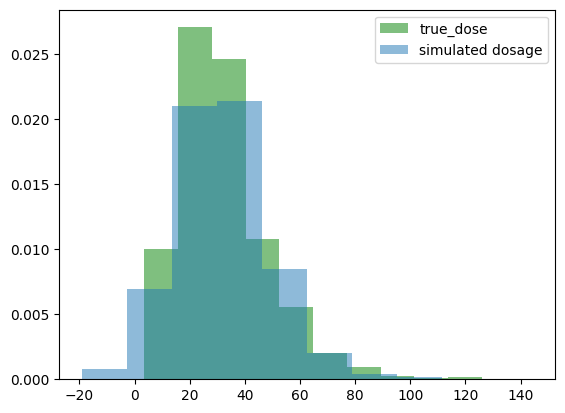

In [5]:
# Global values 
mu_dose = np.mean(therapeut_dose)
std_dose = np.std(therapeut_dose)
mu_bmi = np.mean(X[:,9])
std_bmi = np.std(X[:,9])

# regr = linear_model.LinearRegression()
# regr.fit(X[:,9].reshape([n,1]), therapeut_dose.reshape([n,1]))

theta = 0.5
eps = np.random.normal(size=n)

# eps = np.random.randn(n)
bmi_Z = (X[:,9] - mu_bmi)/std_bmi

# fit on centered model
regr = linear_model.LinearRegression(fit_intercept = False)
regr.fit(bmi_Z.reshape([n,1]), therapeut_dose.reshape([n,1]))


sim_dose = mu_dose  + (np.sqrt(theta)*bmi_Z*std_dose + np.sqrt(1-theta)*std_dose*eps) 
# sim_dose[sim_dose < 0 ] = - sim_dose[sim_dose < 0 ] 
print(np.std(sim_dose))
print(std_dose )

plt.hist(therapeut_dose[therapeut_dose<150],alpha=0.5,color='g',label= 'true_dose', density=True)
plt.hist(sim_dose,alpha = 0.5, label = "simulated dosage", density=True)
plt.legend()

# %%
def simulated_loss(sim_dose, therapeut_dose):
    loss = np.maximum(np.abs(therapeut_dose - sim_dose) - 0.1 * therapeut_dose, np.zeros_like(therapeut_dose))
    return loss + np.random.normal(scale=0.1, size=therapeut_dose.shape)

y_counter = np.asarray(simulated_loss(sim_dose, therapeut_dose))
print(y_counter)

## Propensity score given our treatment generation model from BMI : 
   
where $\epsilon \sim N(0,1)$ and $Z_{BMI} = \frac{x_{BMI} - \mu_{BMI}}{\sigma_{BMI}}$

$$ \mathbb{P}[T_i'=t \mid x_{bmi} ] = \mathbb{P}\left[\epsilon = \frac{t - \mu_T^* - \sigma_T^* \sqrt{\theta}Z_{BMI}}{\sqrt{1 - \theta}} \right]$$

In [6]:
y_counter 


array([ 2.17774307e+00, -4.20752531e-03,  8.79925747e+00, ...,
        2.27090599e+01,  5.13156233e+01, -2.91905521e-02])